In [221]:
# Special functions and optimizations
from scipy.special import gamma, kv  # Bessel function and gamma function
from scipy.stats import multivariate_normal  # Simulation
from scipy.optimize import minimize
from scipy.spatial.distance import cdist  # For space and time distance
from scipy.spatial import distance  # Find closest spatial point
from scipy.optimize import differential_evolution

# Plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns
import torch
# Type hints
from typing import Callable, Union, Tuple

import os
# Add your custom path
import sys
sys.path.append("/cache/home/jl2815/tco")

# Custom imports
from GEMS_TCO import orbitmap 
from GEMS_TCO import kernels 
from GEMS_TCO import evaluate
from GEMS_TCO import load_data_local_computer

import pickle
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import pdist, squareform
import pandas as pd

import matplotlib.transforms as transforms

# Summary

We will explore data on an hourly scale. ```The cyclic pattern``` shown in the ```semivariograms``` indicates that we should fit the data with a model that can explain this cyclic pattern.

Secondly, ```asymmetric cross-variograms``` on some days imply that there is ```space and time interaction```, hence we should consider a non-separable model.

Lastly, ```latitude-sliced``` data shows ```spatial non-stationarity```. I plan to ```detrend for 5x10 spatial points``` in the N5N10 E110E120 region.

In [196]:
# Load the dictionary from the pickle file

for year in ['2024']:
    for month in range(7,8):
        filepath = f'/Users/joonwonlee/Documents/GEMS_DATA/pickle_2024/coarse_cen_map24_{month:02d}.pkl'
        with open(filepath, 'rb') as pickle_file:  
            loaded_map = pickle.load(pickle_file)

        # window
        #filepath = f"C:\\Users\\joonw\\TCO\\GEMS_data\\data_{year}\\sparse_cen_map{year[2:]}_{month:02d}.pkl"
        #with open(filepath, 'rb') as pickle_file:
        #    loaded_map = pickle.load(pickle_file)

for key in loaded_map:
    cur = loaded_map[key]
    # plt.scatter(cur.index, cur['ColumnAmountO3'])
        ## we need to remove outliars
    mask = (cur['ColumnAmountO3'] < 150) | (cur['ColumnAmountO3'] > 300)
    filtered_data = cur[~mask].reset_index(drop=True)
    loaded_map[key] = filtered_data

In [220]:
lat_lon_resolution = [2,2]
mm_cond_number = 20
years = ['2024']
month_range =[7,8]
idx_for_datamap= [0,8]

params= [20, 8.25, 5.25, 0.2, 0.5, 5]

instance = load_data_local_computer()
map, ord_mm, nns_map= instance.load_mm20k_data_bymonthyear( lat_lon_resolution= lat_lon_resolution, mm_cond_number=mm_cond_number,years_=years, months_=month_range)

analysis_data_map, aggregated_data = instance.load_working_data_byday( map, ord_mm, nns_map, idx_for_datamap=[0,240])

# Semivariograms in hourly-scale data. 

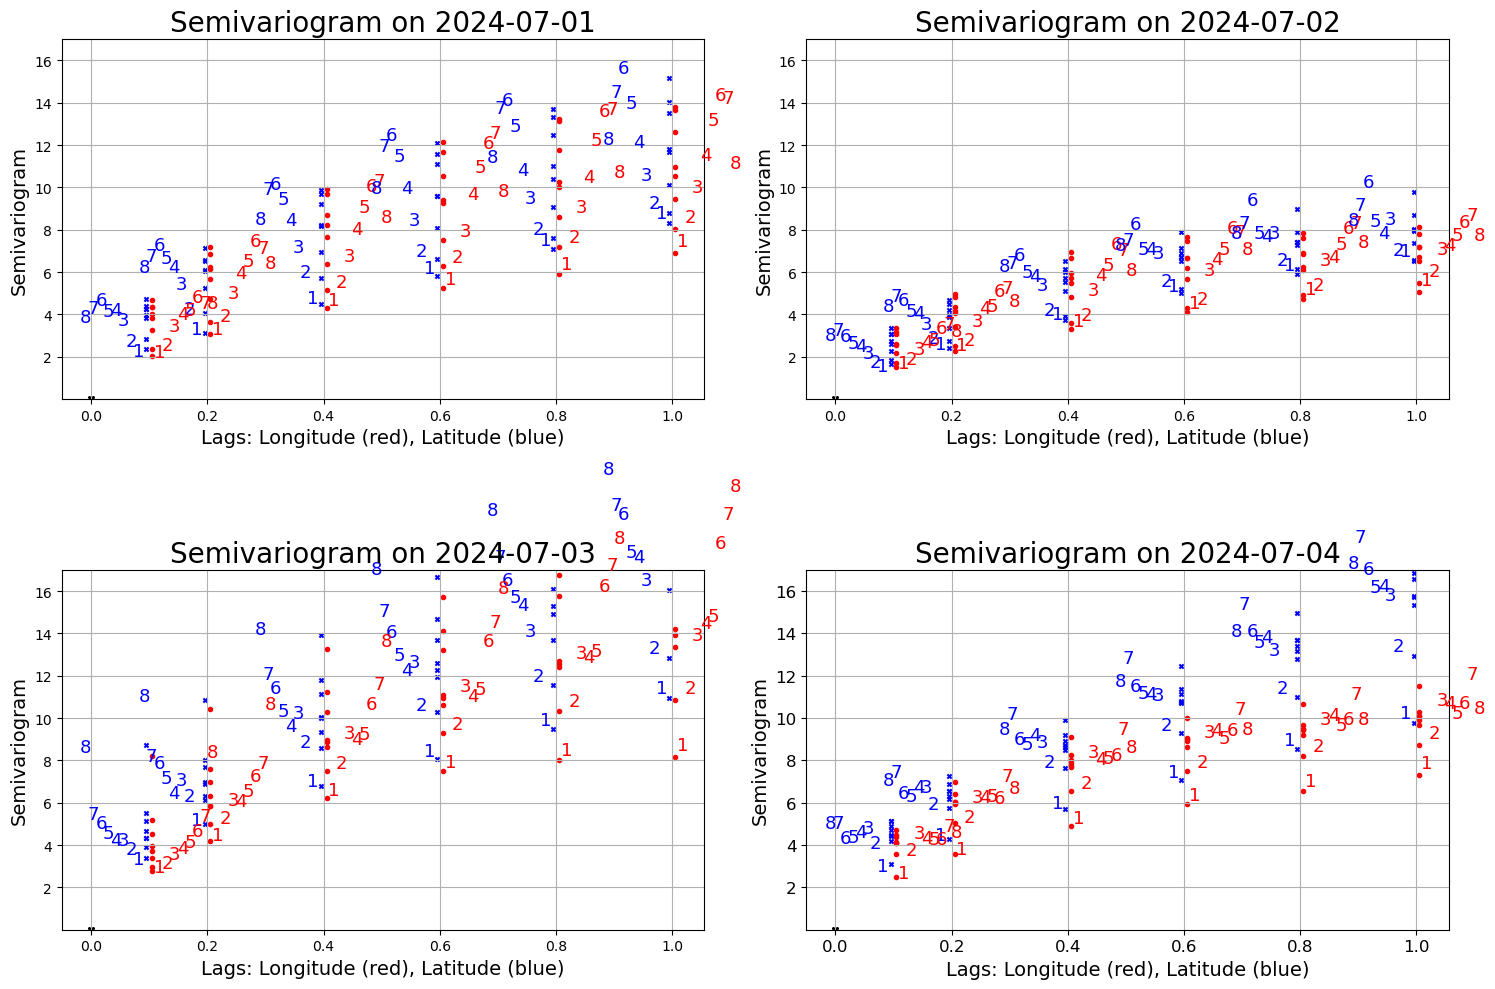

In [ ]:
# Assuming `ori_semi_var_timeseries` and `lags` are defined earlier
cmap = plt.get_cmap('viridis', 9)  # Choose a colormap
days = [1,2,3,4]  # Example days you want to plot
map = analysis_data_map
tolerance = 0.02
# Define 2D lags for latitude and longitude
deltas = [(0,0),(0, 0.1),(0, 0.2), (0, 0.4), (0, 0.6), (0, 0.8), (0, 1) ]
deltas2 = [( 0.1,0), (0.2, 0), (0.4, 0), (0.6, 0), (0.8, 0), (1, 0)]

# Create a 2x2 plot
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for index, day in enumerate(days):
    t = day - 1
    ori_semi_var_timeseries = [[0] * len(deltas) for _ in range(8)]
    ori_semi_var_timeseries2 = [[0] * len(deltas) for _ in range(8)]
    key_list = sorted(map)

    for i in range(8 * t, 8 * t + 8):
        cur_data = map[key_list[i]]

        # coordinates = np.array(cur_data[['Latitude', 'Longitude']])
        coordinates = cur_data[:,:2]
        values = cur_data[:,2]- torch.mean(cur_data[:,2])
        # values = np.array(cur_data['ColumnAmountO3']) - np.mean(np.array(cur_data['ColumnAmountO3']))

        # Calculate pairwise differences in both latitude and longitude
        lat_diffs = coordinates[:, None, 0] - coordinates[None, :, 0]
        lon_diffs = coordinates[:, None, 1] - coordinates[None, :, 1]

        # Calculate the pairwise distances between all points
       

        for j, (delta_lat, delta_lon) in enumerate(deltas):

            valid_pairs = np.where(
                (torch.abs(lat_diffs - delta_lat) <= tolerance) & 
                (torch.abs(lon_diffs - delta_lon) <= tolerance)
            )

            if len(valid_pairs[0]) == 0:
                print(f"No valid pairs found for t{j+1:02d}_{i+1} at delta ({delta_lat}, {delta_lon})")
                ori_semi_var_timeseries[i % 8][j] = np.nan
                continue

            # Compute the semivariance for those valid pairs
            semivariances = 0.5 * torch.mean((values[valid_pairs[0]] - values[valid_pairs[1]]) ** 2)

            # Normalize the semivariance
            variance_of_data = torch.var(values)
            normalized_semivariance = semivariances / variance_of_data
            normalized_semivariance = semivariances

            # Append the normalized semivariance to the timeseries
            ori_semi_var_timeseries[i % 8][j] = normalized_semivariance

        for j, (delta_lat, delta_lon) in enumerate(deltas2):

            valid_pairs2 = np.where(
                (np.abs(lat_diffs - delta_lat) <= tolerance) & 
                (np.abs(lon_diffs - delta_lon) <= tolerance)
            )
            
            semivariances2 = 0.5 * torch.mean((values[valid_pairs2[0]] - values[valid_pairs2[1]]) ** 2)
            normalized_semivariance2 = semivariances2 / variance_of_data
            normalized_semivariance2 = semivariances2
            ori_semi_var_timeseries2[i % 8][j] = normalized_semivariance2


    # Plotting all orbits for the current day
    ax = axs[index // 2, index % 2]

    x_values = []
    for j, (lat, lon) in enumerate(deltas):
        if lat < 0 or lon < 0:
            x_values.append(lon )  # Use negative index for negative lags
        else:
            x_values.append(lon)   # Use positive index for positive lags
    x_values2 = []
    for j, (lat, lon) in enumerate(deltas2):
        if lat < 0 or lon < 0:
            x_values2.append(lat )  # Use negative index for negative lags
        else:
            x_values2.append(lat)   # Use positive index for positive lags  
    x_values = [x + 0.005 for x in x_values]              
    x_values2 = [x - 0.005 for x in x_values2]
    for i in range(8):
        color = cmap(i / 9)

        weight = [-0.5, -0.25, -0.15, -0.05, 0, 0.05, 0.15, 0.25, 0.5]
        weight2 = [0.01,0.02, 0.03, 0.04, 0.05, 0.06, 0.07,0.08]

        min_y1 = min(ori_semi_var_timeseries[i])
        min_y2 = min(ori_semi_var_timeseries2[i])
        # Plot longitude lags (red points with numbers)
        for j, (x, y) in enumerate(zip(x_values, ori_semi_var_timeseries[i])):
            if j>=1:
                ax.scatter(x, y, marker='o', s=9, color= 'red')
                ax.text(x+ weight2[i]*1.3, y + weight[j], str(i + 1), fontsize=13, color='red', ha='center', va='bottom')
            else:
                ax.scatter(0,0, marker='x', s=15, color='black')

        # Plot latitude lags (blue points with numbers)
        for j, (x, y) in enumerate(zip(x_values2, ori_semi_var_timeseries2[i])):
            ax.scatter(x, y, marker='x', s=9, color='blue')
            ax.text(x- weight2[i]*1.3, y + weight[j], str(i + 1), fontsize=13, color='blue', ha='center', va='bottom')
    ax.grid(True)
    # ax.legend(loc='upper right', markerscale=1.5, framealpha=0.1, bbox_to_anchor=(1.2,1.0))
    ax.set_xlabel('Lags: Longitude (red), Latitude (blue)', fontsize=14)
    # ax.set_ylabel('Normalized Semivariogram')
    ax.set_ylabel('Semivariogram' , fontsize=14)
    ax.set_title(f'Semivariogram on 2024-07-{day:02d}', fontsize=20)
    # ax.set_title(f'log-log scaled Semivariogram in 2024-07-{day:02d}')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    ax.set_xscale('linear')
    ax.set_yscale('linear')
    ax.set_ylim(1e-4,17)
    
plt.tight_layout()
plt.show()

# Cross Variograms

The cross variograms show whether there is an interaction between space and time. If it is symmetric, then there is little or negligible interaction, whereas asymmetric cross variogram indicates there is an interaction between space and time.

When there is space and time interaction, we should consider non-seprable spatio-temporal models.

### Cross variograms (Longitude lag)


In [ ]:
class CrossVariogram:
    def __init__(self):
        pass

    def cross_lon_lat(self,deltas, map,  days, tolerance):
        lon_lag_sem = {}
        lon_lag_sem[0] = deltas
        for index, day in enumerate(days):
            lon_lag_sem[day] = [[0]*len(deltas) for _ in range(7)]
            t = day - 1
            ori_semi_var_timeseries = [[0] * len(deltas) for _ in range(7)]
            key_list = sorted(map)
            
            for i in range(8 * t, 8 * t + 7):         # change 7 to 6
                cur_data = map[key_list[i]]
                next_data = map[key_list[i+1]]
                # coordinates = np.array(cur_data[['Latitude', 'Longitude']])
                # cur_values = np.array(cur_data['ColumnAmountO3']) - np.mean(np.array(cur_data['ColumnAmountO3']))
                coordinates = cur_data[:,:2]
                cur_values = cur_data[:,2]- torch.mean(cur_data[:,2])

                # next_values = np.array(next_data['ColumnAmountO3']) - torch.mean( np.array(next_data['ColumnAmountO3'])  )
                next_values = (next_data[:,2]) - torch.mean( (next_data[:,2]) )
                # Calculate pairwise differences in both latitude and longitude
                lat_diffs = coordinates[:, None, 0] - coordinates[None, :, 0]
                lon_diffs = coordinates[:, None, 1] - coordinates[None, :, 1]

                # Calculate the pairwise distances between all points
            
                for j, (delta_lat, delta_lon) in enumerate(deltas):

                    valid_pairs = np.where(
                        (np.abs(lat_diffs - delta_lat) <= tolerance) & 
                        (np.abs(lon_diffs - delta_lon) <= tolerance)
                    )
            
                    if len(valid_pairs[0]) == 0:
                        print(f"No valid pairs found for t{j+1:02d}_{i+1} at delta ({delta_lat}, {delta_lon})")
                        ori_semi_var_timeseries[i % 8][j] = np.nan
                        continue
                    # Compute the semivariance for those valid pairs
                    semivariances = 0.5 * torch.mean(( cur_values[valid_pairs[1]] - next_values[valid_pairs[0]]  ) ** 2)

                    # Normalize the semivariance
                    #variance_of_data = torch.var(values)
                    #normalized_semivariance = semivariances 

                    # Append the normalized semivariance to the timeseries
                    lon_lag_sem[day][i % 8][j] = semivariances.item()
                    ori_semi_var_timeseries[i % 8][j] = semivariances.item() 
        return lon_lag_sem

    def cross_directional_sem(self,deltas, map,  days, tolerance, direction1, direction2):
        directional_sem = {}
        directional_sem[0] = deltas

        for index, day in enumerate(days):
            directional_sem[day] = [[0]*len(deltas) for _ in range(7)]
            
            t = day - 1
            ori_semi_var_timeseries = [[0] * len(deltas) for _ in range(7)]
            key_list = sorted(map)

            for i in range(8 * t, 8 * t + 7):         # change 7 to 6
                cur_data = map[key_list[i]]
                next_data = map[key_list[i+1]]
                coordinates = cur_data[:,:2]   # latitude and longitude
                cur_values = cur_data[:,2]- torch.mean(cur_data[:,2])
                next_values = (next_data[:,2]) - torch.mean( (next_data[:,2]) )

                # Calculate pairwise differences in both latitude and longitude
                lat_diffs = coordinates[:, None, 0] - coordinates[None, :, 0]
                lon_diffs = coordinates[:, None, 1] - coordinates[None, :, 1]

                # Calculate the pairwise distances between all points

                angle = np.arctan2(lat_diffs, lon_diffs) 
                direction1_filter = np.abs(angle - direction1) <= np.pi/8 
                direction2_filter = np.abs(angle -direction2) <= np.pi/8

                for j, (distance) in enumerate(deltas):


                    if j<= len(deltas)/2:
                        direction_filtered = direction1_filter
                        direction = direction1
                    else:
                        direction_filtered = direction2_filter
                        direction = direction2
                    
                    # Apply the boolean mask directly to the 2D arrays
                    filtered_lat_diffs = lat_diffs*direction_filtered
                    filtered_lon_diffs = lon_diffs*direction_filtered

            
                    # Check if we have valid filtered lat/lon diffs
                    # print(filtered_lat_diffs,filtered_lat_diffs.shape)  # Check the filtered lat diffs before the comparison

                    if distance==0:
                        valid_pairs = np.where(
                            (np.abs(np.sqrt(lat_diffs**2 + lon_diffs**2) - distance) <= tolerance)
                        )
                    else:
                        valid_pairs = np.where(
                            (filtered_lat_diffs != 0) &  # allow earlier filter
                            (np.abs(np.sqrt(filtered_lat_diffs**2 + filtered_lon_diffs**2) - distance) <= tolerance)
                        )

                    if len(valid_pairs[0]) == 0:
                        print(f"No valid pairs found for t{j+1:02d}_{i+1} at lag ({distance},  direction {direction})")
                        ori_semi_var_timeseries[i % 8][j] = np.nan
                        continue

                    # Compute the semivariance for those valid pairs
                    semivariances = 0.5 * torch.mean((cur_values[valid_pairs[0]] - next_values[valid_pairs[1]]) ** 2)
                    
                    # Normalize the semivariance
                    # variance_of_data = np.var(values)
                    # normalized_semivariance = semivariances / variance_of_data

                    directional_sem[day][i % 8][j] = semivariances.item()
                    # Append the normalized semivariance to the timeseries
                    ori_semi_var_timeseries[i % 8][j] = semivariances.item()
                
        return directional_sem

    def plot_lon_sem(self,map, lon_lag_sem, days, deltas):
        fig, axs = plt.subplots(2, 2, figsize=(15, 10))

        for index, day in enumerate(days):
            t = day - 1
            key_list = sorted(map)

            # Create a 2x2 plot
            ax = axs[index // 2, index % 2]

            # Separate positive and negative lags and assign appropriate indices
            x_values = []
            for j, (lat, lon) in enumerate(deltas):
                x_values.append(lon)  # Use negative index for negative lags
            # weight = [-0.55, -0.5, -0.25, -0.15, -0.05, 0, 0.05, 0.15, 0.25, 0.5, 0.55]
            # weight2 = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08]

            # Plotting for each orbit
            for i in range(7):
                for j, (x, y) in enumerate(zip(x_values, lon_lag_sem[day][i])):
                    ax.scatter(x, y, marker='o', s=9, color='black')
                    # ax.text(x + weight2[i] * 1.5, y + weight[j] * 0.5, str(i + 1), fontsize=9, color='blue', ha='center', va='bottom')

                # Apply offset using transforms
                    offset = transforms.ScaledTranslation(0.04 * i, 0.04 * j, fig.dpi_scale_trans)
                    
                    trans = ax.transData + offset
                    ax.text(x, y, str(i + 1), fontsize=9, color='blue', ha='center', va='bottom', transform=trans)

            ax.grid(True)
            ax.set_xlabel('Longitude Lags', fontsize=12)
            ax.set_ylabel('Cross-Variogram Value', fontsize=12)
            ax.set_title(f'Cross-Variogram on 2024-07-{day:02d}', fontsize=14)
            ax.set_xscale('linear')  # Linear scale for x-axis
            ax.set_yscale('linear')  # Linear scale for y-axis
            ax.set_xticks(x_values)
            ticks = [ str( round(x,1)) for x in x_values]
            ax.set_xticklabels(ticks)
            ax.set_ylim(1e-4, 30)
            # Rotate x-axis labels by 45 degrees
            plt.setp(ax.get_xticklabels(), rotation=60, ha='right')

        plt.tight_layout()
        plt.show()

    def plot_lat_sem(self,map, lon_lag_sem, days, deltas):
        fig, axs = plt.subplots(2, 2, figsize=(15, 10))

        for index, day in enumerate(days):
            t = day - 1
            key_list = sorted(map)

            # Create a 2x2 plot
            ax = axs[index // 2, index % 2]

            # Separate positive and negative lags and assign appropriate indices
            x_values = []
            for j, (lat, lon) in enumerate(deltas):
                x_values.append(lat)  # Use negative index for negative lags
            # weight = [-0.55, -0.5, -0.25, -0.15, -0.05, 0, 0.05, 0.15, 0.25, 0.5, 0.55]
            # weight2 = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08]

            # Plotting for each orbit
            for i in range(7):
                for j, (x, y) in enumerate(zip(x_values, lon_lag_sem[day][i])):
                    ax.scatter(x, y, marker='o', s=9, color='black')
                    # ax.text(x + weight2[i] * 1.5, y + weight[j] * 0.5, str(i + 1), fontsize=9, color='blue', ha='center', va='bottom')

                    offset = transforms.ScaledTranslation(0.04 * i, 0.04 * j, fig.dpi_scale_trans)
                    
                    trans = ax.transData + offset
                    ax.text(x, y, str(i + 1), fontsize=9, color='blue', ha='center', va='bottom', transform=trans)


            ax.grid(True)
            ax.set_xlabel('Latitude Lags', fontsize=12)
            ax.set_ylabel('Cross-Variogram Value', fontsize=12)
            ax.set_title(f'Cross-Variogram on 2024-07-{day:02d}', fontsize=14)
            ax.set_xscale('linear')  # Linear scale for x-axis
            ax.set_yscale('linear')  # Linear scale for y-axis
            ax.set_xticks(x_values)
            ticks = [ str( round(x,1)) for x in x_values]
            ax.set_xticklabels(ticks)
            ax.set_ylim(1e-4, 30)
        # Rotate x-axis labels by 45 degrees
            plt.setp(ax.get_xticklabels(), rotation=60, ha='right')

        plt.tight_layout()
        plt.show()


    def plot_directional_sem(self,x_values,direictional_sem, days, direction1, direction2):
        fig, axs = plt.subplots(2, 2, figsize=(15, 10))

        for index, day in enumerate(days):
            # Create a 2x2 plot
            ax = axs[index // 2, index % 2]

            # weight = [-0.55, -0.5, -0.25, -0.15, -0.05, 0, 0.05, 0.15, 0.25, 0.5, 0.55]
            # weight2 = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08]

            # Plotting for each orbit
            for i in range(7):
                for j, (x, y) in enumerate(zip(x_values, direictional_sem[day][i])):
                    ax.scatter(x, y, marker='o', s=9, color='black')
                   # ax.text(x + weight2[i] * 1.5, y + weight[j] * 0.5, str(i + 1), fontsize=9, color='blue', ha='center', va='bottom')
                    offset = transforms.ScaledTranslation(0.04 * i, 0.04 * j, fig.dpi_scale_trans)
                    
                    
                    trans = ax.transData + offset
                    ax.text(x, y, str(i + 1), fontsize=9, color='blue', ha='center', va='bottom', transform=trans)

            ax.grid(True)
            ax.set_xlabel('Euclidean disstance', fontsize=12)
            ax.set_ylabel('Cross-Variogram Value', fontsize=12)
            ax.set_title(f'Directional Cross-Variogram {(direction1*(180/np.pi)) ,(direction2*(180/np.pi))} on 2024-07-{day:02d}', fontsize=14)
            ax.set_xscale('linear')  # Linear scale for x-axis
            ax.set_yscale('linear')  # Linear scale for y-axis
            ax.set_xticks(x_values)
            ticks = [ str( round(x,1)) for x in x_values]
            ax.set_xticklabels(ticks)
            ax.set_ylim(1e-4, 30)


        # Rotate x-axis labels by 45 degrees
            plt.setp(ax.get_xticklabels(), rotation=60, ha='right')

        plt.tight_layout()
        plt.show()

        

In [288]:
# deltas = [(0,0), (0, 0.2), (0, 0.4), (0, 0.6), (0, 0.8), (0, 1) ]
# Include negative deltas
# deltas += [(d[0], -d[1]) for d in deltas if d[1] != 0] + [(-d[0], d[1]) for d in deltas if d[0] != 0]

tmp = np.concatenate((np.linspace(-2, -0.2, 10), [-0.1, 0, 0.1], np.linspace(0.2, 2, 10)))
deltas = [ (0, round(a,1)) for a in tmp]

days = [12,13]  # Example days you want to plot
map = analysis_data_map
tolerance = 0.02

instance_sem = CrossVariogram()
lon_lag_sem = instance_sem.cross_lon_lat(deltas, map, days, tolerance)

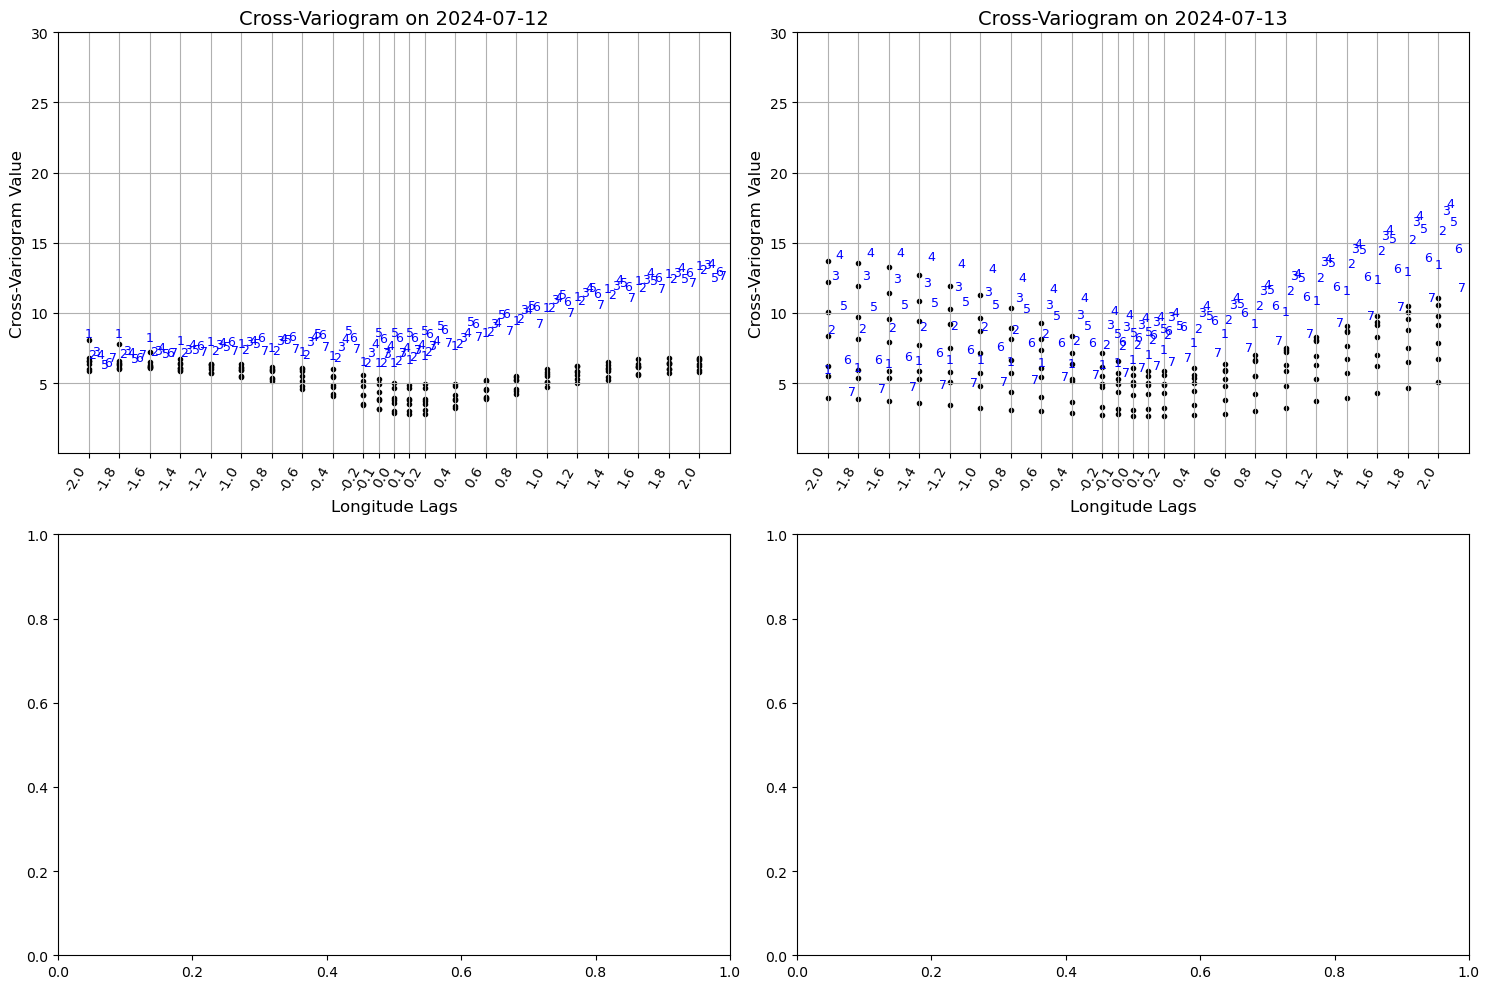

In [289]:
days = [12,13]
instance_sem.plot_lon_sem(map, lon_lag_sem,days,deltas)

### Cross variograms (Latitude lag)

In [286]:
# deltas = [ (0,0), (0.2, 0), (0.4, 0), (0.6, 0), (0.8, 0), (1, 0)]
# deltas += [(d[0], -d[1]) for d in deltas if d[1] != 0] + [(-d[0], d[1]) for d in deltas if d[0] != 0]

tmp = np.concatenate((np.linspace(-2, -0.2, 10), [-0.1, 0, 0.1], np.linspace(0.2, 2, 10)))
deltas = [ ( round(a,1),0 ) for a in tmp]

days = [12,13]  # Example days you want to plot
map =  analysis_data_map
tolerance = 0.02

instance_sem = CrossVariogram()
lat_lag_sem = instance_sem.cross_lon_lat(deltas, map, days, tolerance)

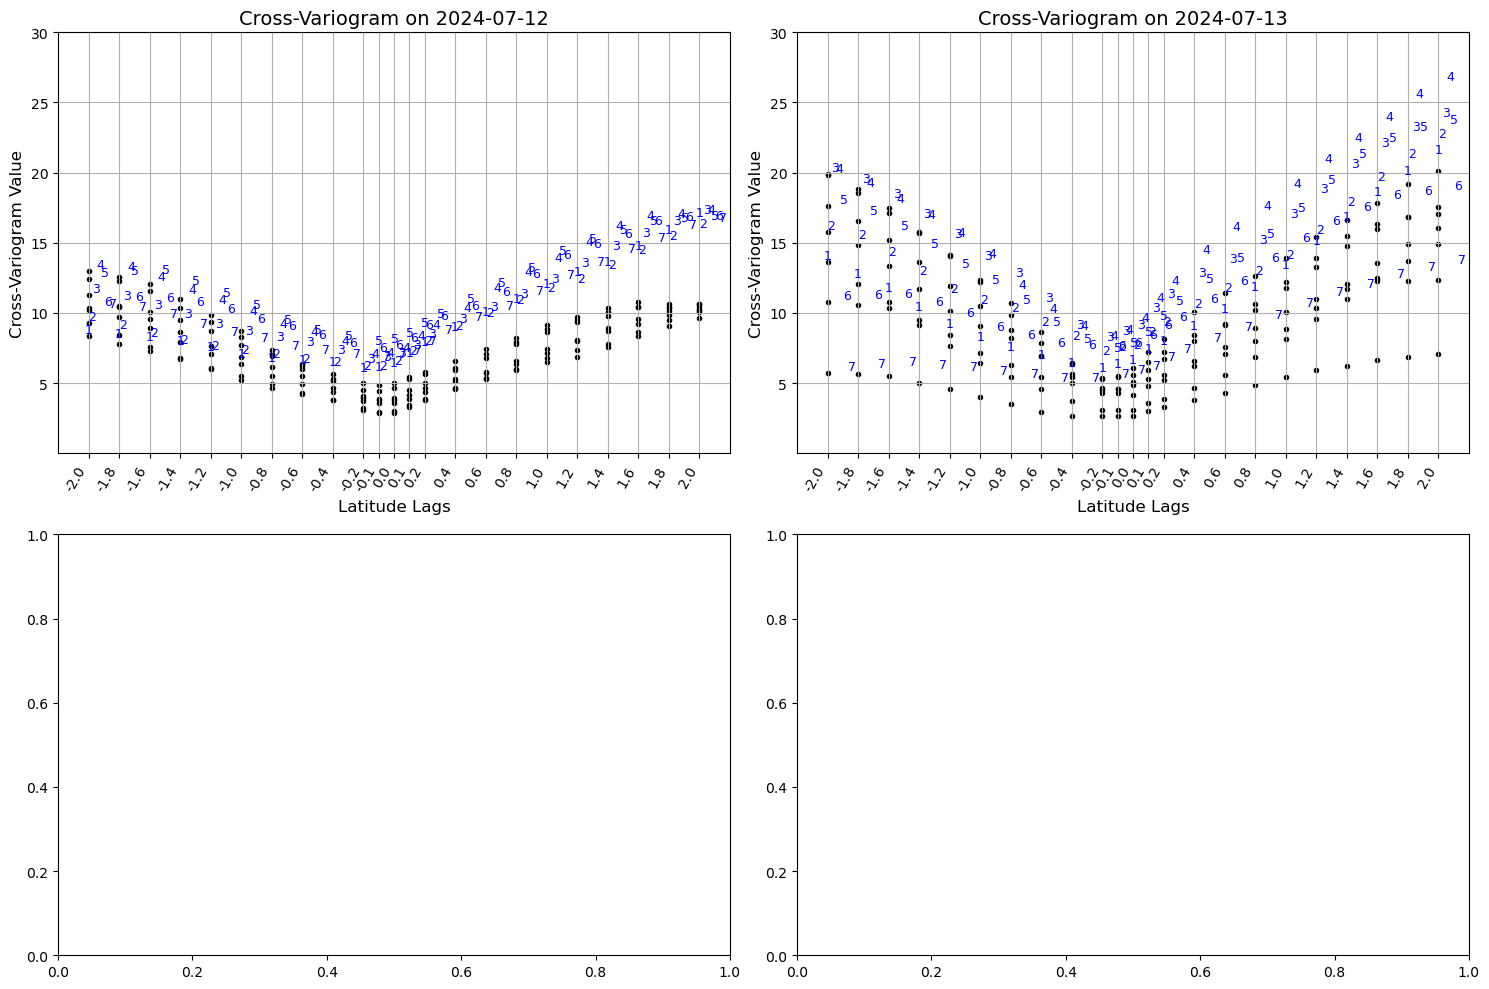

In [287]:
instance_sem.plot_lat_sem(map, lon_lag_sem,days,deltas)

### Cross variograms (along the line y=x)

In [ ]:
d45 = np.arctan2(1,1)
d135 = np.arctan2(-1,-1)  

# neg_deltas = [ 1, 0.8,0.6, 0.4 ,0.2, 0]
# pos_deltas = [ 0.2, 0.4, 0.6, 0.8, 1.0]
# deltas = neg_deltas + pos_deltas

deltas = np.concatenate(( np.linspace(2, 0.2, 10), [0.1, 0, 0.1], np.linspace(0.2, 2, 10)))

days = [12]  # Example days you want to plot
map  = analysis_data_map
tolerance = 0.03  # no pairs for 0.02

instance_sem = CrossVariogram()
d135_45_sem = instance_sem.cross_directional_sem(deltas, map,  days, tolerance, direction1=d135, direction2=d45)


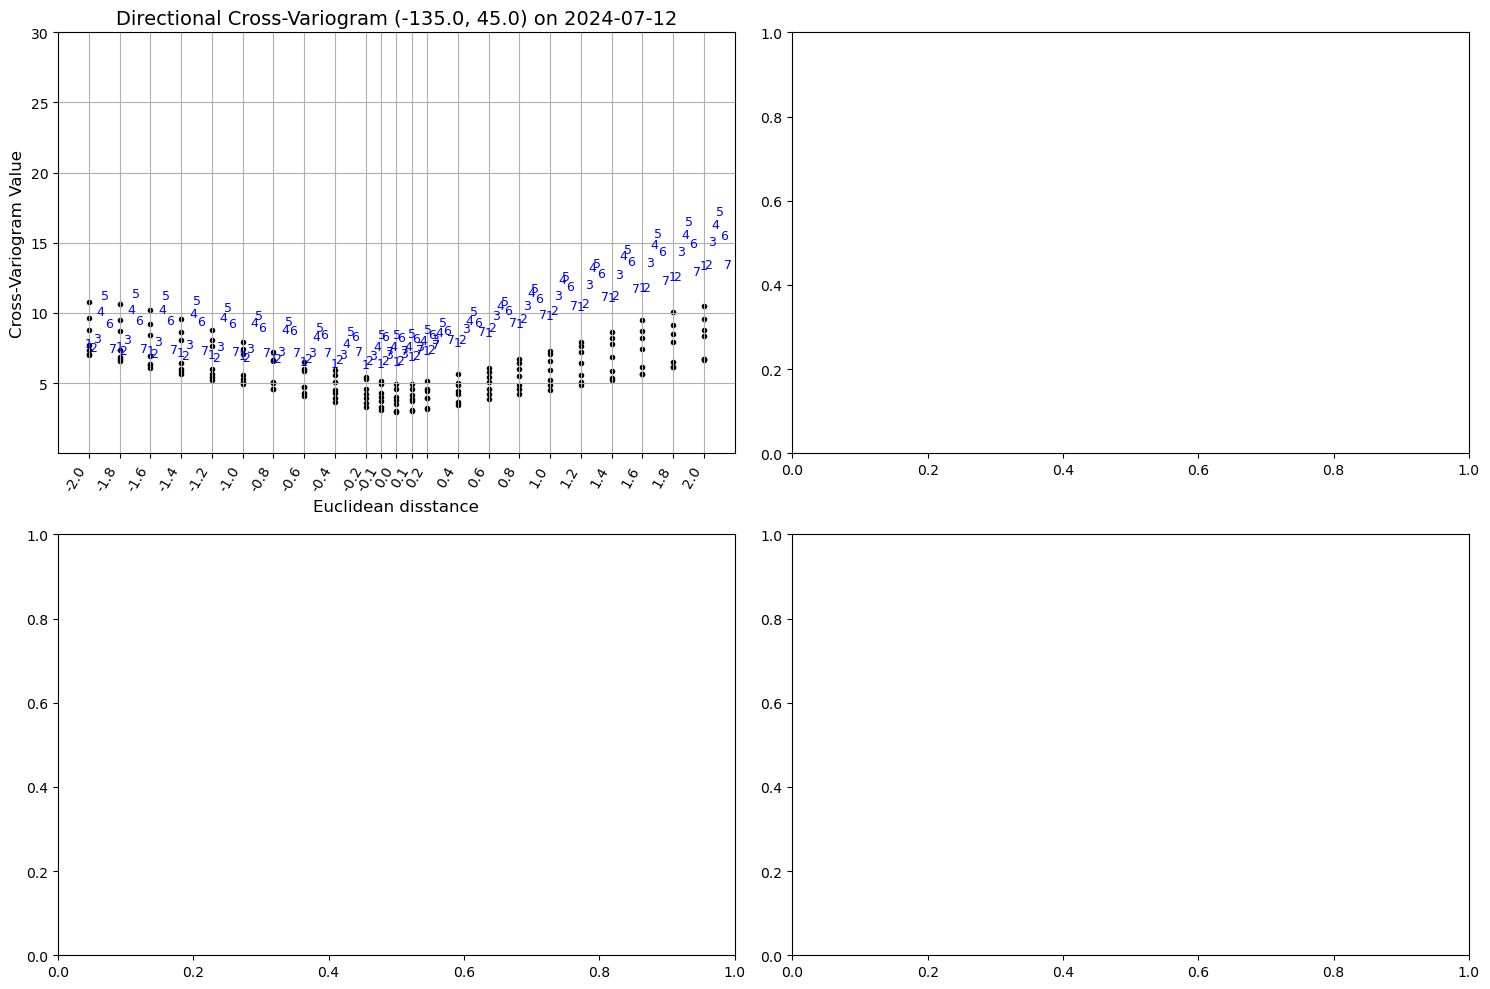

In [ ]:
instance_sem = CrossVariogram()

# x_values = [-1, -.8, -.6, -.4, -.2, 0, 0.2, 0.4, 0.6, 0.8, 1]

days = [12] 
x_values = np.concatenate((np.linspace(-2, -0.2, 10), [-0.1, 0, 0.1], np.linspace(0.2, 2, 10)))

instance_sem.plot_directional_sem(x_values, d135_45_sem, days, d135, d45)


### Cross variograms (along the line y=-x)

In [ ]:
dn45 = np.arctan2(-1,1)
dn135 = np.arctan2(1,-1)
# neg_deltas = [ 1, 0.8,0.6, 0.4 ,0.2, 0]
# pos_deltas = [ 0.2, 0.4, 0.6, 0.8, 1.0]
# deltas = neg_deltas + pos_deltas

deltas = np.concatenate(( np.linspace(2, 0.2, 10), [0.1, 0, 0.1], np.linspace(0.2, 2, 10)))

days = [12,13,14,15]  # Example days you want to plot
map = analysis_data_map
tolerance = 0.03  # no pairs for 0.02

instance_sem = CrossVariogram()
dn45_n135_sem = instance_sem.cross_directional_sem(deltas, map,  days, tolerance, direction1=dn45, direction2=dn135)



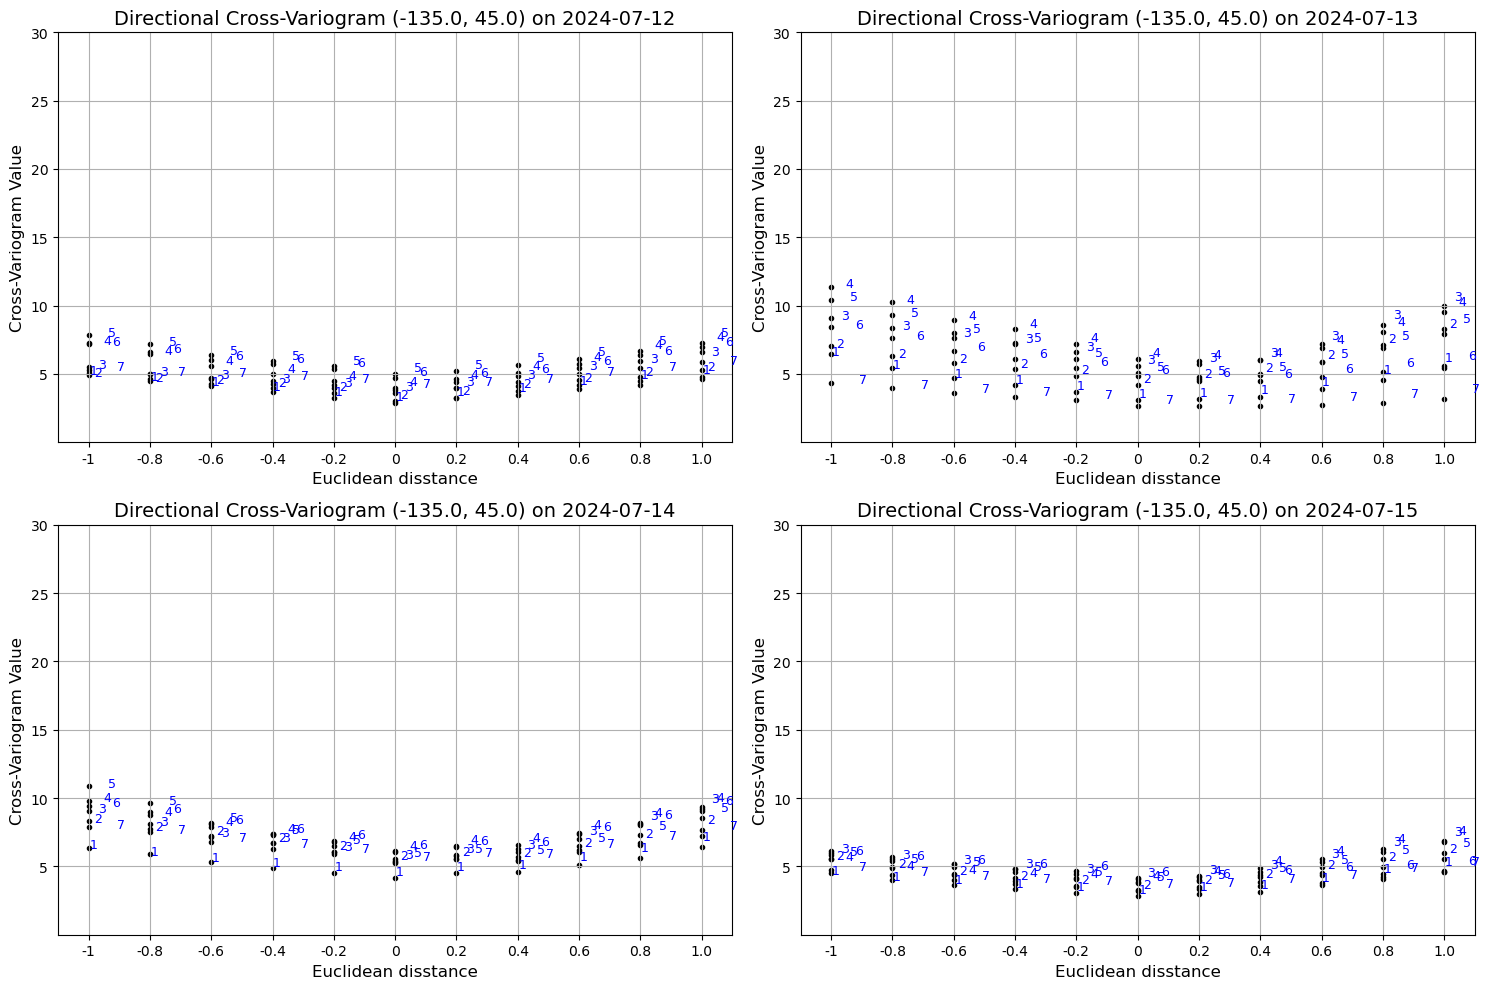

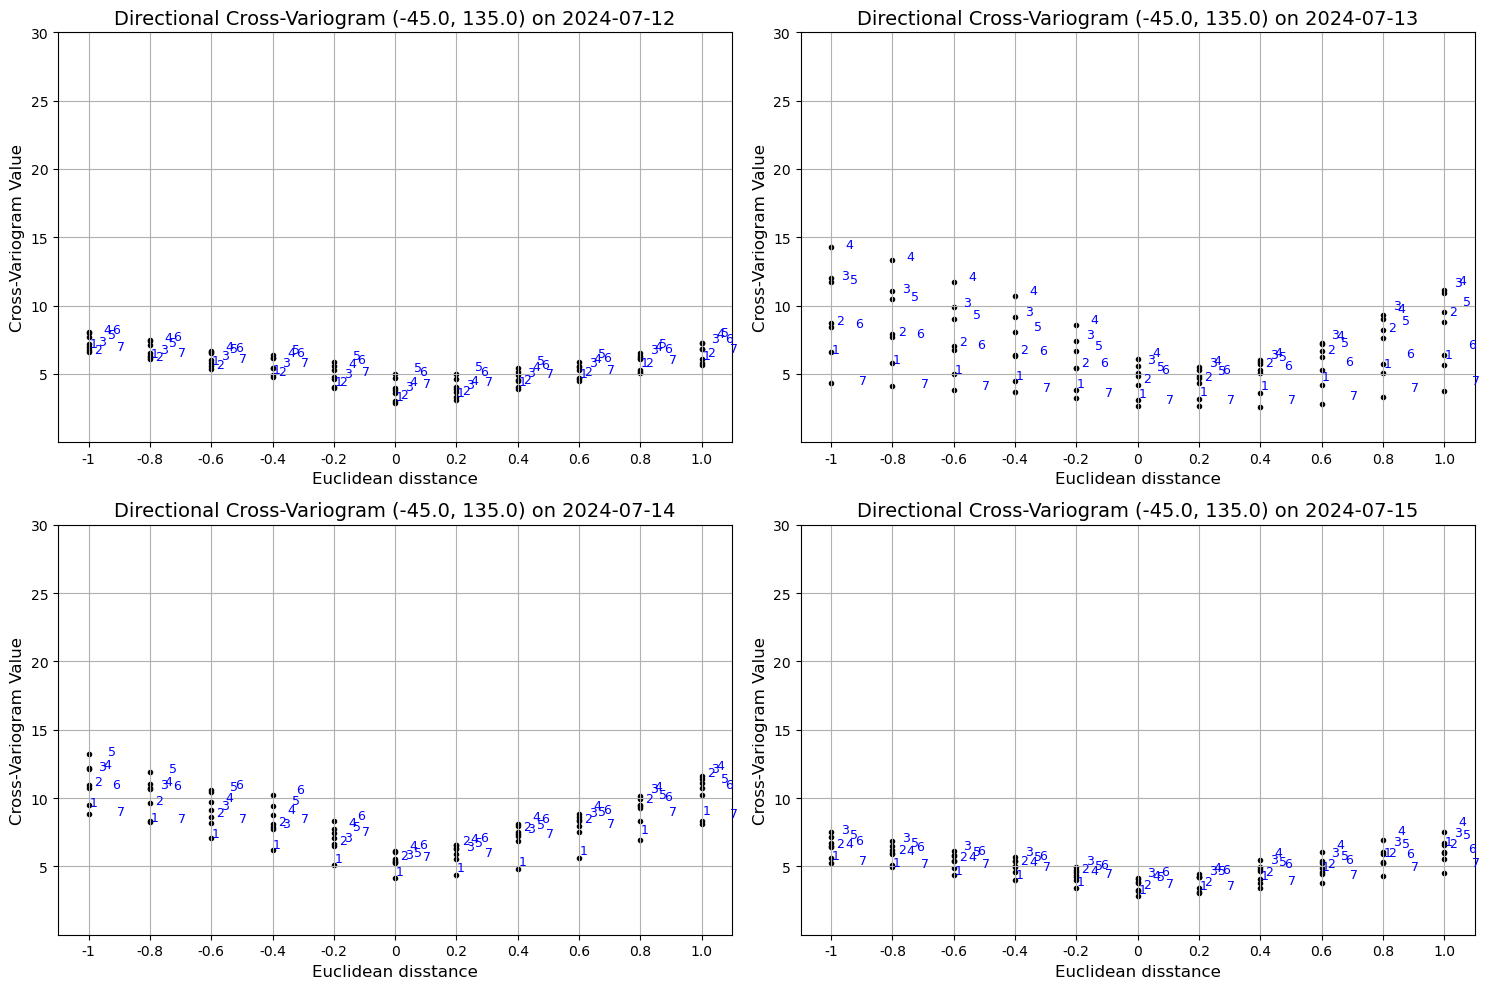

In [ ]:
instance_sem = CrossVariogram()
# x_values = [-1, -.8, -.6, -.4, -.2, 0, 0.2, 0.4, 0.6, 0.8, 1]

x_values = np.concatenate((np.linspace(-2, -0.2, 10), [-0.1, 0, 0.1], np.linspace(0.2, 2, 10)))

instance_sem.plot_directional_sem(x_values, d135_45_sem, days, d135,d45)
instance_sem.plot_directional_sem(x_values, dn45_n135_sem, days, dn45,dn135)

## Plot the realization of the ```ozone process```, ```semivariogram```, and ```cross-variogram``` simultaneously using ```latitude-sliced data```.

Note data data is demeaned.


I will make separate data map into 5 maps, each contains latitude_sliced data.

In [7]:
coarse_map_lat5_to_6 = {}
coarse_map_lat6_to_7 = {}
coarse_map_lat7_to_8 = {}
coarse_map_lat8_to_9 = {}
coarse_map_lat9_to_10 = {}

for key in coarse_map24_7:
    data = coarse_map24_7[key]
    coarse_map_lat5_to_6[key] = data[(data['Latitude'] >= 5) & (data['Latitude'] < 6)]
    coarse_map_lat6_to_7[key] = data[(data['Latitude'] >= 6) & (data['Latitude'] < 7)]
    coarse_map_lat7_to_8[key] = data[(data['Latitude'] >= 7) & (data['Latitude'] < 8)]
    coarse_map_lat8_to_9[key] = data[(data['Latitude'] >= 8) & (data['Latitude'] < 9)]
    coarse_map_lat9_to_10[key] = data[(data['Latitude'] >= 9) & (data['Latitude'] <= 10)]

In [10]:
output_dir = r"C:\\Users\\joonw\\TCO\\pipeline_2025\\outputs" # r raw string

In [29]:
def make_plot(map,k):# Assuming `ori_semi_var_timeseries` and `lags` are defined earlier
    cmap = plt.get_cmap('viridis', 9)  # Choose a colormap
    days = [8]  # Example days you want to plot
    
    tolerance = 0.02
    # Define 2D lags for latitude and longitude
    deltas = [(0,0),(0, 0.2), (0, 0.4), (0, 0.6), (0, 0.8) ]
    deltas2 = [(0.2, 0), (0.4, 0), (0.6, 0), (0.8, 0), ]

    plot_file = os.path.join(output_dir, f"Plots_latitude_slice_{k}_{k+1}.png")


    fig, axs = plt.subplots(1,2, figsize=(16, 6))

    for index, day in enumerate(days):
        t = day - 1
        sem_timeseries = [[0] * len(deltas) for _ in range(8)]
        cross_timeseries2 = [[0] * len(deltas) for _ in range(8)]
        key_list = sorted(map)

        for i in range(8 * t, 8 * t + 8):
            cur_data = map[key_list[i]]
            coordinates = np.array(cur_data[['Latitude', 'Longitude']])

            if cur_data['ColumnAmountO3'].empty:
                print('error: Empty ColumnAmountO3 data')

            values = np.array(cur_data['ColumnAmountO3']) - np.mean(np.array(cur_data['ColumnAmountO3']))

            # Calculate pairwise differences in both latitude and longitude
            lat_diffs = coordinates[:, None, 0] - coordinates[None, :, 0]
            lon_diffs = coordinates[:, None, 1] - coordinates[None, :, 1]

            # Calculate the pairwise distances between all points
        

            for j, (delta_lat, delta_lon) in enumerate(deltas):

                valid_pairs = np.where(
                    (np.abs(lat_diffs - delta_lat) <= tolerance) & 
                    (np.abs(lon_diffs - delta_lon) <= tolerance)
                )

                if len(valid_pairs[0]) == 0:
                    print(f"No valid pairs found for t{j+1:02d}_{i+1} at delta ({delta_lat}, {delta_lon})")
                    sem_timeseries[i % 8][j] = np.nan
                    continue


                tmp = (values[valid_pairs[0]] - values[valid_pairs[1]])
                if tmp.size==0:
                    print('error: tmp in plot_0')

                # Compute the semivariance for those valid pairs
                semivariances = 0.5 * np.mean(tmp ** 2)

                # Normalize the semivariance
                variance_of_data = np.var(values)
                normalized_semivariance = semivariances / variance_of_data
                normalized_semivariance = semivariances

                # Append the normalized semivariance to the timeseries
                sem_timeseries[i % 8][j] = normalized_semivariance

            for j, (delta_lat, delta_lon) in enumerate(deltas2):

                valid_pairs2 = np.where(
                    (np.abs(lat_diffs - delta_lat) <= tolerance) & 
                    (np.abs(lon_diffs - delta_lon) <= tolerance)
                )
                
                semivariances2 = 0.5 * np.mean((values[valid_pairs2[0]] - values[valid_pairs2[1]]) ** 2)
                normalized_semivariance2 = semivariances2 / variance_of_data
                normalized_semivariance2 = semivariances2
                cross_timeseries2[i % 8][j] = normalized_semivariance2


        # Plotting all orbits for the current day
        ax = axs[1]

        x_values = []
        for j, (lat, lon) in enumerate(deltas):
            if lat < 0 or lon < 0:
                x_values.append(lon )  # Use negative index for negative lags
            else:
                x_values.append(lon)   # Use positive index for positive lags
        x_values2 = []
        for j, (lat, lon) in enumerate(deltas2):
            if lat < 0 or lon < 0:
                x_values2.append(lat )  # Use negative index for negative lags
            else:
                x_values2.append(lat)   # Use positive index for positive lags  
        x_values = [x + 0.005 for x in x_values]              
        x_values2 = [x - 0.005 for x in x_values2]
        for i in range(8):
            color = cmap(i / 9)

            weight = [-0.5, -0.25, -0.15, -0.05, 0, 0.05, 0.15, 0.25, 0.5]
            weight2 = [0.01,0.02, 0.03, 0.04, 0.05, 0.06, 0.07,0.08]

            min_y1 = min(sem_timeseries[i])
            min_y2 = min(cross_timeseries2[i])
            # Plot longitude lags (red points with numbers)
            for j, (x, y) in enumerate(zip(x_values, sem_timeseries[i])):
                if j>=1:
                    ax.scatter(x, y, marker='o', s=9, color= 'red')
                    ax.text(x+ weight2[i]*1.3, y + weight[j], str(i + 1), fontsize=13, color='red', ha='center', va='bottom')
                else:
                    ax.scatter(0,0, marker='x', s=15, color='black')

            # Plot latitude lags (blue points with numbers)
            for j, (x, y) in enumerate(zip(x_values2, cross_timeseries2[i])):
                ax.scatter(x, y, marker='x', s=9, color='blue')
                ax.text(x- weight2[i]*1.3, y + weight[j], str(i + 1), fontsize=13, color='blue', ha='center', va='bottom')
        ax.grid(True)
        # ax.legend(loc='upper right', markerscale=1.5, framealpha=0.1, bbox_to_anchor=(1.2,1.0))
        ax.set_xlabel('Lags: Longitude (red), Latitude (blue)', fontsize=14)
        # ax.set_ylabel('Normalized Semivariogram')
        ax.set_ylabel('Semivariogram' , fontsize=14)
        ax.set_title(f'Semivariogram on 2024-07-{day:02d}', fontsize=20)
        # ax.set_title(f'log-log scaled Semivariogram in 2024-07-{day:02d}')
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        ax.set_xscale('linear')
        ax.set_yscale('linear')
        ax.set_ylim(1e-4,40)
        

    # Assuming `ori_semi_var_timeseries` and `lags` are defined earlier
    cmap = plt.get_cmap('tab10', 9)  # Choose a colormap
    # days = [3,8,13,25]  # Example days you want to plot
    map = coarse_map24_7
    tolerance = 0.02
    # Define 2D lags for latitude and longitude

    deltas = [(0,0), (0, 0.2), (0, 0.4), (0, 0.6), (0, 0.8), (0, 1) ]
    # Include negative deltas
    deltas += [(d[0], -d[1]) for d in deltas if d[1] != 0] + [(-d[0], d[1]) for d in deltas if d[0] != 0]


    for index, day in enumerate(days):
        t = day - 1
        sem_timeseries = [[0] * len(deltas) for _ in range(7)]
        key_list = sorted(map)

        for i in range(8 * t, 8 * t + 7):         # change 7 to 6
            cur_data = map[key_list[i]]
            next_data = map[key_list[i+1]]
            coordinates = np.array(cur_data[['Latitude', 'Longitude']])

            if cur_data['ColumnAmountO3'].empty or next_data['ColumnAmountO3'].empty:
                print('error: Empty ColumnAmountO3 data')

            cur_values = np.array(cur_data['ColumnAmountO3']) - np.mean(np.array(cur_data['ColumnAmountO3']))
            next_values = np.array(next_data['ColumnAmountO3']) - np.mean( np.array(next_data['ColumnAmountO3'])  )
            # Calculate pairwise differences in both latitude and longitude
            lat_diffs = coordinates[:, None, 0] - coordinates[None, :, 0]
            lon_diffs = coordinates[:, None, 1] - coordinates[None, :, 1]

            # Calculate the pairwise distances between all points
        
            for j, (delta_lat, delta_lon) in enumerate(deltas):

                valid_pairs = np.where(
                    (np.abs(lat_diffs - delta_lat) <= tolerance) & 
                    (np.abs(lon_diffs - delta_lon) <= tolerance)
                )
        
                if len(valid_pairs[0]) == 0:
                    print(f"No valid pairs found for t{j+1:02d}_{i+1} at delta ({delta_lat}, {delta_lon})")
                    sem_timeseries[i % 8][j] = np.nan
                    continue
                # Compute the semivariance for those valid pairs

                tmp = ( cur_values[valid_pairs[1]] - next_values[valid_pairs[0]]  )
                if tmp.size==0:
                    print('error: tmp for sem empty')

                semivariances = 0.5 * np.mean( tmp ** 2)

    
                sem_timeseries[i % 8][j] = semivariances

    # third
    ax = axs[0]
    for index, day in enumerate(days):
        t = day - 1
        sem_timeseries = [[0] * len(deltas) for _ in range(8)]
        cross_timeseries2 = [[0] * len(deltas) for _ in range(8)]
        key_list = sorted(map)


        length_lat = 1
        lat_k = k

        for i in range(8 * t, 8 * t + 8):
            cur_data = map[key_list[i]]
            # cur_data.sort_values('Longitude', inplace=True)
            cur_data = cur_data[(cur_data['Latitude'] >= lat_k) & (cur_data['Latitude'] <= lat_k+ length_lat)]

            coordinates = np.array(cur_data[['Latitude', 'Longitude']])
            values = np.array(cur_data['ColumnAmountO3']) - np.mean(np.array(cur_data['ColumnAmountO3']))

            ax.plot(cur_data['Longitude'], cur_data['ColumnAmountO3'] +(i%8)*10, label=f'Orbit {i%8+1}')

        ax.grid(True)
        ax.legend(loc='upper right', markerscale=1.5, framealpha=0.1, bbox_to_anchor=(1.2,1.0))
        ax.set_xlabel('Longitude', fontsize=14)
        # ax.set_ylabel('Normalized Semivariogram')
        ax.set_ylabel('' , fontsize=14)
        ax.set_title(f'Latitude {(lat_k,lat_k+length_lat)} on 2024-07-{day:02d}', fontsize=20)
        # ax.set_title(f'log-log scaled Semivariogram in 2024-07-{day:02d}')
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        ax.set_xscale('linear')
        ax.set_yscale('linear')
        ax.set_ylim(250,350)
        ax.set_yticklabels([])

    plt.tight_layout()
    plt.savefig(plot_file)
    plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

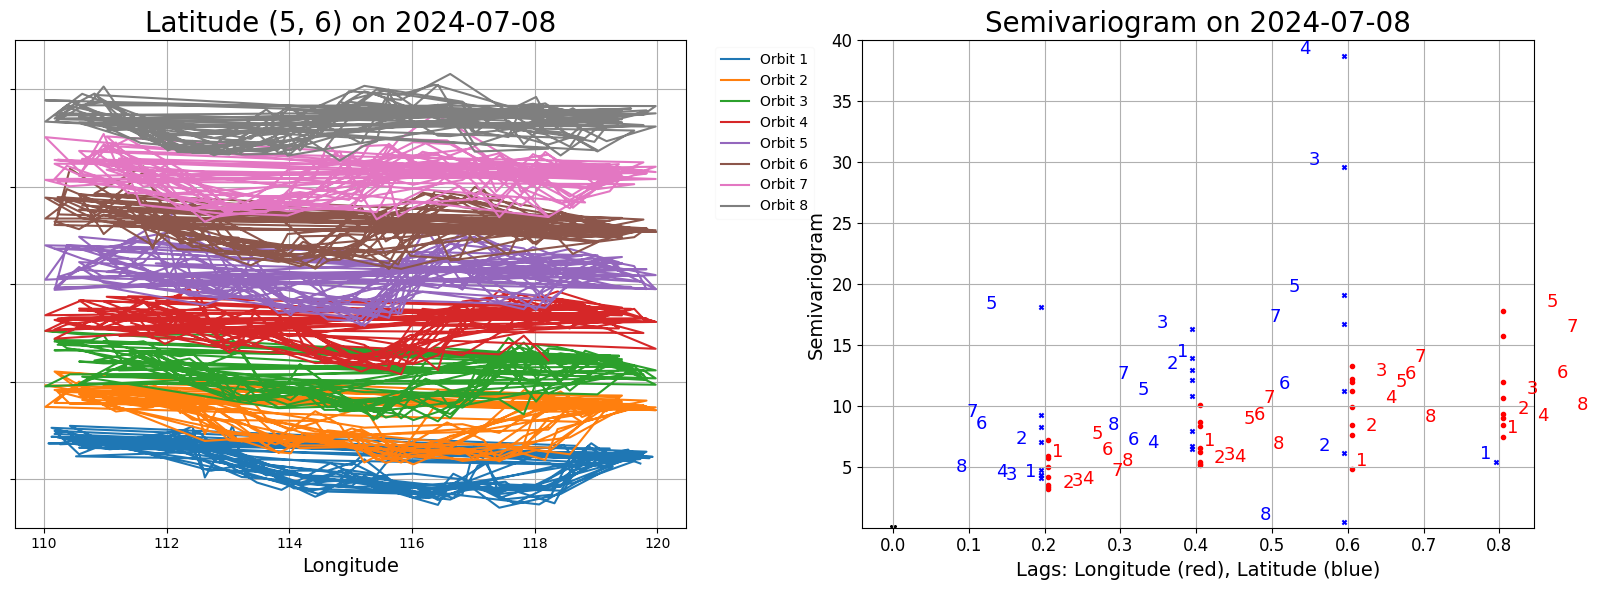

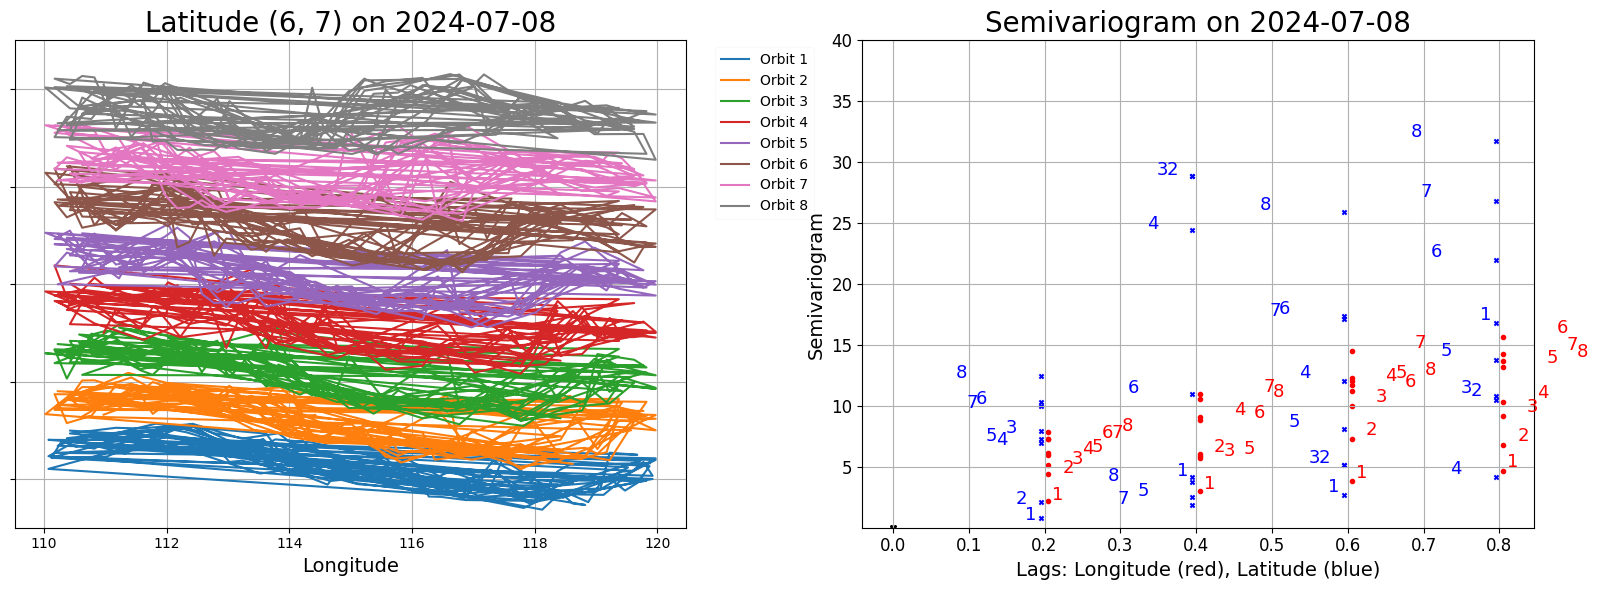

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


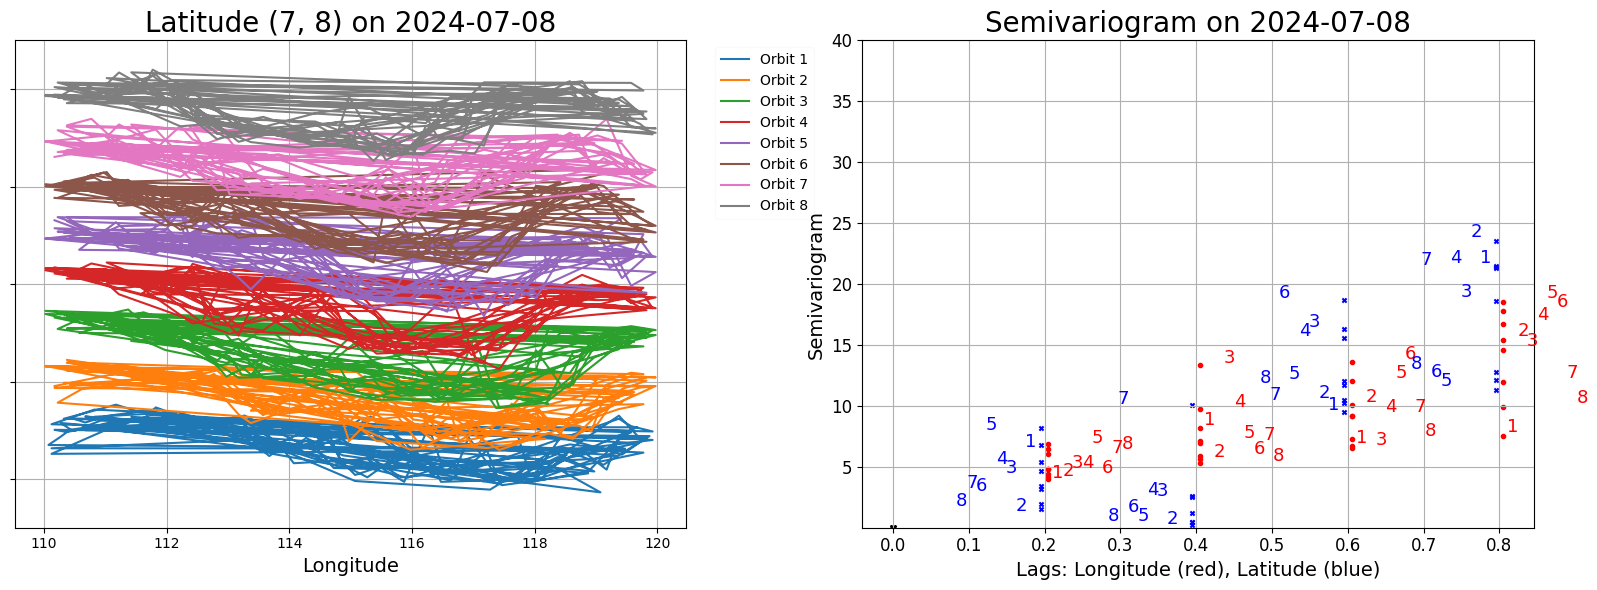

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


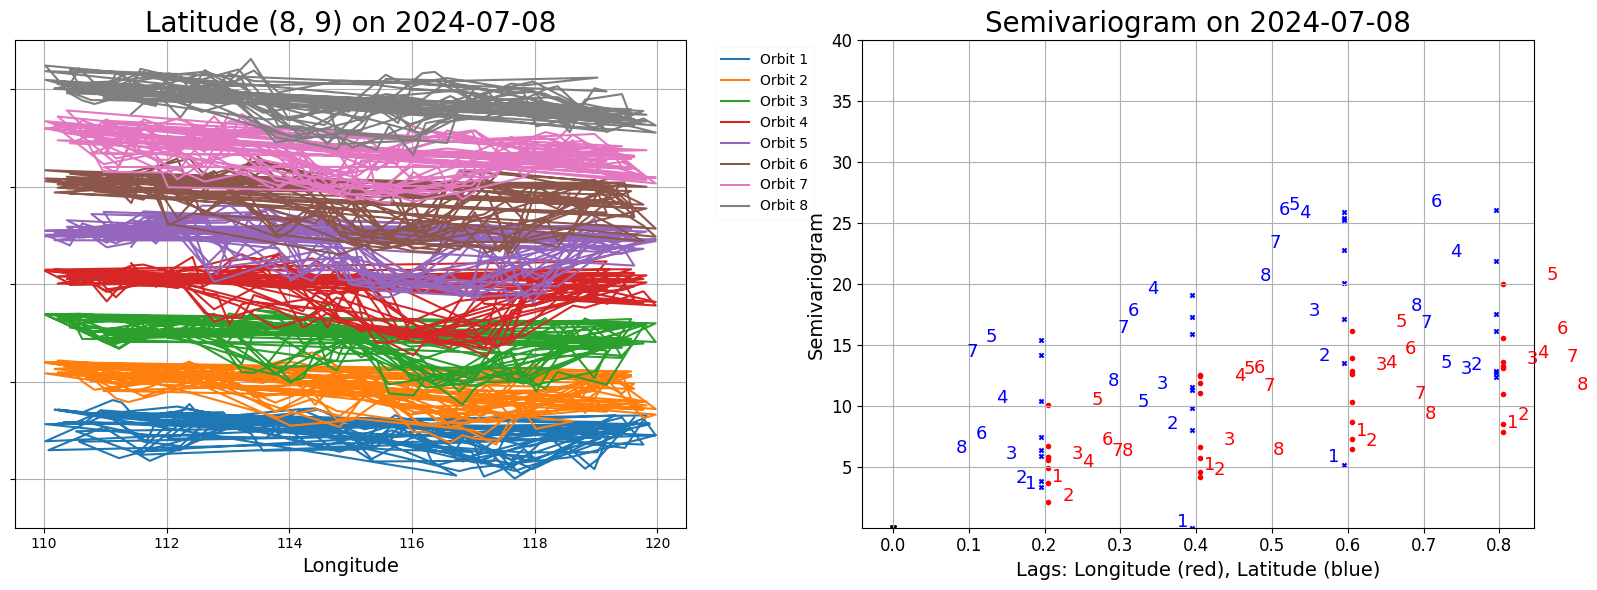

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

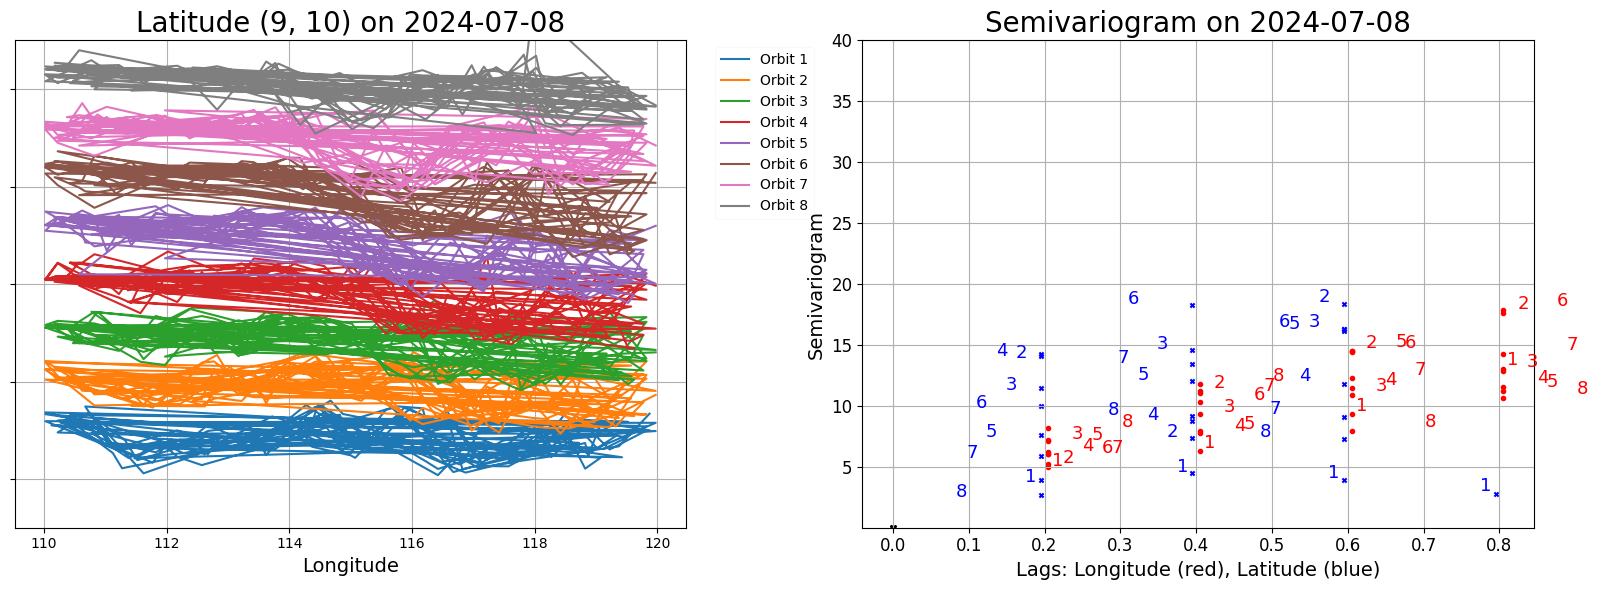

In [30]:
import warnings
# Suppress specific Matplotlib warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", message="posx and posy should be finite values")
import warnings
warnings.filterwarnings("ignore")


make_plot(coarse_map_lat5_to_6,5)
make_plot(coarse_map_lat6_to_7,6)
make_plot(coarse_map_lat7_to_8,7)
make_plot(coarse_map_lat8_to_9,8)
make_plot(coarse_map_lat9_to_10,9)

## Realization of ozone process of latitude-sliced data

In [102]:
length_lat = .5
days = [30]  # Example days you want to plot

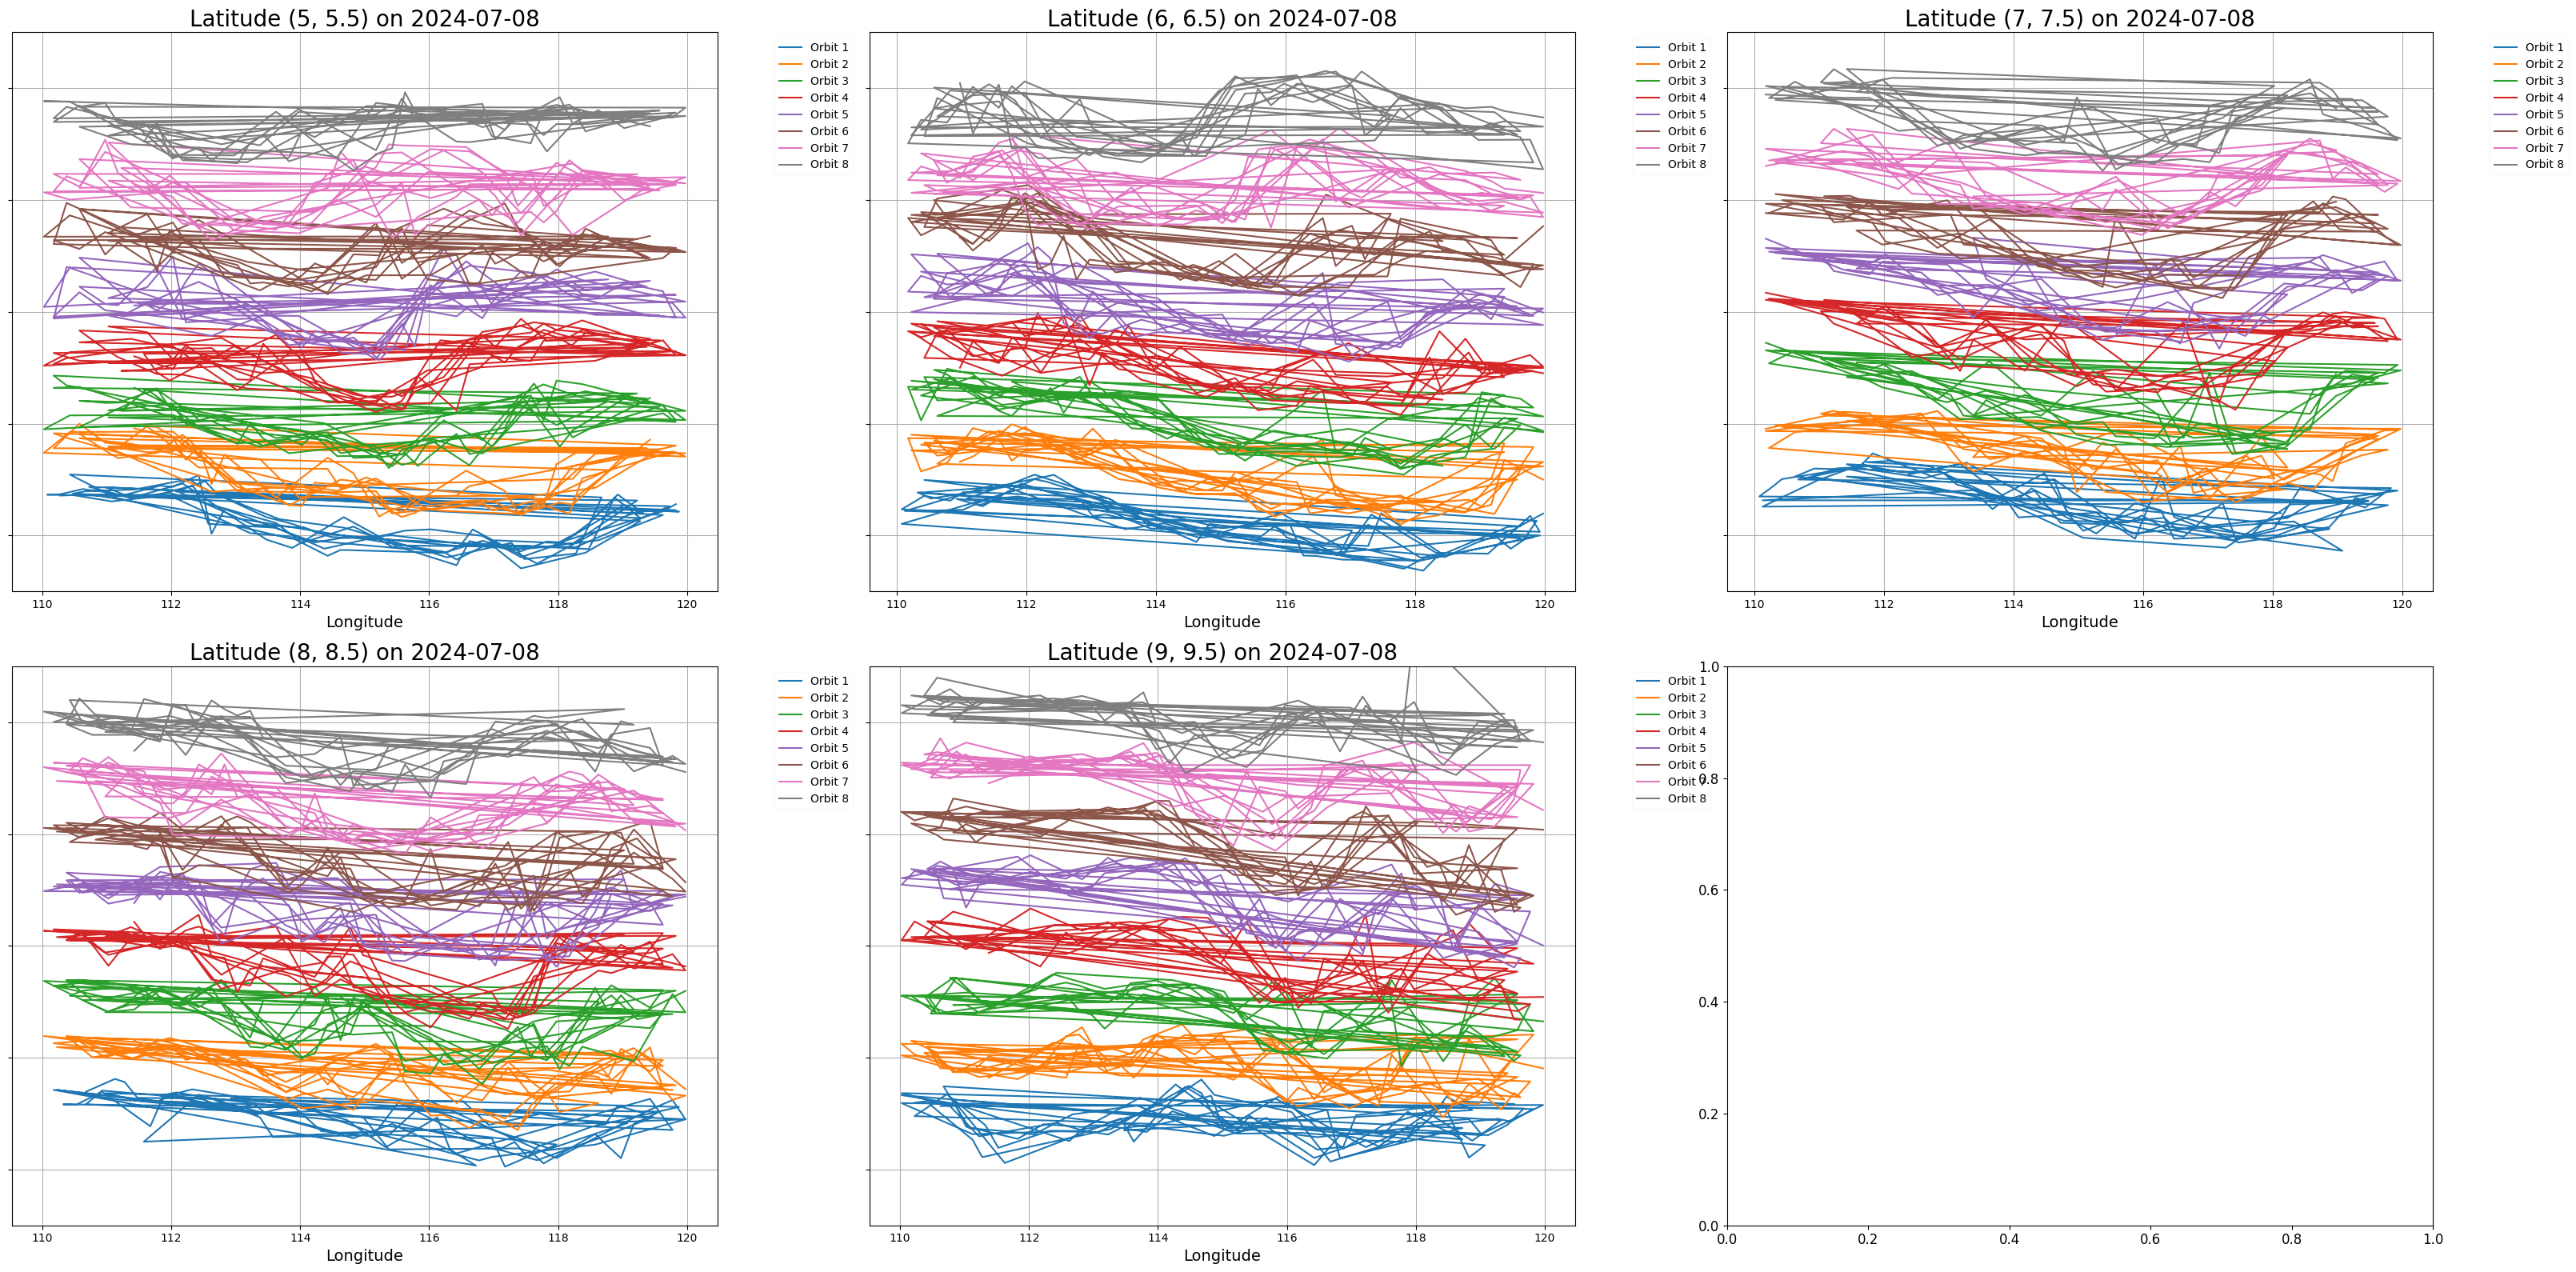

In [11]:
# Assuming `ori_semi_var_timeseries` and `lags` are defined earlier
cmap = plt.get_cmap('viridis', 9)  # Choose a colormap

map = coarse_map24_7
tolerance = 0.02
# Define 2D lags for latitude and longitude
deltas = [(0,0),(0, 0.2), (0, 0.4), (0, 0.6), (0, 0.8), (0, 1) ]
deltas2 = [(0.2, 0), (0.4, 0), (0.6, 0), (0.8, 0), (1, 0)]

# Create a 2x2 plot
fig, axs = plt.subplots(2,3, figsize=(32, 16))



# third
ax = axs[0][0]
for index, day in enumerate(days):
    t = day - 1
    ori_semi_var_timeseries = [[0] * len(deltas) for _ in range(8)]
    ori_semi_var_timeseries2 = [[0] * len(deltas) for _ in range(8)]
    key_list = sorted(map)

    lat_k = 5
    for i in range(8 * t, 8 * t + 8):
        cur_data = map[key_list[i]]
        # cur_data.sort_values('Longitude', inplace=True)
        cur_data = cur_data[(cur_data['Latitude'] >= lat_k) & (cur_data['Latitude'] <= lat_k+length_lat)]

        coordinates = np.array(cur_data[['Latitude', 'Longitude']])
        values = np.array(cur_data['ColumnAmountO3']) - np.mean(np.array(cur_data['ColumnAmountO3']))

        ax.plot(cur_data['Longitude'], cur_data['ColumnAmountO3'] +(i%8)*10, label=f'Orbit {i%8+1}')

    ax.grid(True)
    ax.legend(loc='upper right', markerscale=1.5, framealpha=0.1, bbox_to_anchor=(1.2,1.0))
    ax.set_xlabel('Longitude', fontsize=14)
    # ax.set_ylabel('Normalized Semivariogram')
    ax.set_ylabel('' , fontsize=14)
    ax.set_title(f'Latitude {(lat_k,lat_k+length_lat)} on 2024-07-{day:02d}', fontsize=20)
    # ax.set_title(f'log-log scaled Semivariogram in 2024-07-{day:02d}')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    ax.set_xscale('linear')
    ax.set_yscale('linear')
    ax.set_ylim(250,350)
    ax.set_yticklabels([])

ax = axs[0][1]
for index, day in enumerate(days):
    t = day - 1
    ori_semi_var_timeseries = [[0] * len(deltas) for _ in range(8)]
    ori_semi_var_timeseries2 = [[0] * len(deltas) for _ in range(8)]
    key_list = sorted(map)

    lat_k = 6
    for i in range(8 * t, 8 * t + 8):
        cur_data = map[key_list[i]]
        # cur_data.sort_values('Longitude', inplace=True)
        cur_data = cur_data[(cur_data['Latitude'] >= lat_k) & (cur_data['Latitude'] <= lat_k+length_lat)]

        coordinates = np.array(cur_data[['Latitude', 'Longitude']])
        values = np.array(cur_data['ColumnAmountO3']) - np.mean(np.array(cur_data['ColumnAmountO3']))

        ax.plot(cur_data['Longitude'], cur_data['ColumnAmountO3'] +(i%8)*10, label=f'Orbit {i%8+1}')

    ax.grid(True)
    ax.legend(loc='upper right', markerscale=1.5, framealpha=0.1, bbox_to_anchor=(1.2,1.0))
    ax.set_xlabel('Longitude', fontsize=14)
    # ax.set_ylabel('Normalized Semivariogram')
    ax.set_ylabel('' , fontsize=14)
    ax.set_title(f'Latitude {(lat_k,lat_k+length_lat)} on 2024-07-{day:02d}', fontsize=20)
    # ax.set_title(f'log-log scaled Semivariogram in 2024-07-{day:02d}')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    ax.set_xscale('linear')
    ax.set_yscale('linear')
    ax.set_ylim(250,350)
    ax.set_yticklabels([])

ax = axs[0][2]
for index, day in enumerate(days):
    t = day - 1
    ori_semi_var_timeseries = [[0] * len(deltas) for _ in range(8)]
    ori_semi_var_timeseries2 = [[0] * len(deltas) for _ in range(8)]
    key_list = sorted(map)

    lat_k = 7
    for i in range(8 * t, 8 * t + 8):
        cur_data = map[key_list[i]]
        # cur_data.sort_values('Longitude', inplace=True)
        cur_data = cur_data[(cur_data['Latitude'] >= lat_k) & (cur_data['Latitude'] <= lat_k+length_lat)]

        coordinates = np.array(cur_data[['Latitude', 'Longitude']])
        values = np.array(cur_data['ColumnAmountO3']) - np.mean(np.array(cur_data['ColumnAmountO3']))

        ax.plot(cur_data['Longitude'], cur_data['ColumnAmountO3'] +(i%8)*10, label=f'Orbit {i%8+1}')

    ax.grid(True)
    ax.legend(loc='upper right', markerscale=1.5, framealpha=0.1, bbox_to_anchor=(1.2,1.0))
    ax.set_xlabel('Longitude', fontsize=14)
    # ax.set_ylabel('Normalized Semivariogram')
    ax.set_ylabel('' , fontsize=14)
    ax.set_title(f'Latitude {(lat_k,lat_k+length_lat)} on 2024-07-{day:02d}', fontsize=20)
    # ax.set_title(f'log-log scaled Semivariogram in 2024-07-{day:02d}')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    ax.set_xscale('linear')
    ax.set_yscale('linear')
    ax.set_ylim(250,350)
    ax.set_yticklabels([])


ax = axs[1][0]
for index, day in enumerate(days):
    t = day - 1
    ori_semi_var_timeseries = [[0] * len(deltas) for _ in range(8)]
    ori_semi_var_timeseries2 = [[0] * len(deltas) for _ in range(8)]
    key_list = sorted(map)

    lat_k = 8
    for i in range(8 * t, 8 * t + 8):
        cur_data = map[key_list[i]]
        # cur_data.sort_values('Longitude', inplace=True)
        cur_data = cur_data[(cur_data['Latitude'] >= lat_k) & (cur_data['Latitude'] <= lat_k+length_lat)]

        coordinates = np.array(cur_data[['Latitude', 'Longitude']])
        values = np.array(cur_data['ColumnAmountO3']) - np.mean(np.array(cur_data['ColumnAmountO3']))

        ax.plot(cur_data['Longitude'], cur_data['ColumnAmountO3'] +(i%8)*10, label=f'Orbit {i%8+1}')

    ax.grid(True)
    ax.legend(loc='upper right', markerscale=1.5, framealpha=0.1, bbox_to_anchor=(1.2,1.0))
    ax.set_xlabel('Longitude', fontsize=14)
    # ax.set_ylabel('Normalized Semivariogram')
    ax.set_ylabel('' , fontsize=14)
    ax.set_title(f'Latitude {(lat_k,lat_k+length_lat)} on 2024-07-{day:02d}', fontsize=20)
    # ax.set_title(f'log-log scaled Semivariogram in 2024-07-{day:02d}')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    ax.set_xscale('linear')
    ax.set_yscale('linear')
    ax.set_ylim(250,350)
    ax.set_yticklabels([])

ax = axs[1][1]
for index, day in enumerate(days):
    t = day - 1
    ori_semi_var_timeseries = [[0] * len(deltas) for _ in range(8)]
    ori_semi_var_timeseries2 = [[0] * len(deltas) for _ in range(8)]
    key_list = sorted(map)

    lat_k = 9
    for i in range(8 * t, 8 * t + 8):
        cur_data = map[key_list[i]]
        # cur_data.sort_values('Longitude', inplace=True)
        cur_data = cur_data[(cur_data['Latitude'] >= lat_k) & (cur_data['Latitude'] <= lat_k+ length_lat)]

        coordinates = np.array(cur_data[['Latitude', 'Longitude']])
        values = np.array(cur_data['ColumnAmountO3']) - np.mean(np.array(cur_data['ColumnAmountO3']))

        ax.plot(cur_data['Longitude'], cur_data['ColumnAmountO3'] +(i%8)*10, label=f'Orbit {i%8+1}')

    ax.grid(True)
    ax.legend(loc='upper right', markerscale=1.5, framealpha=0.1, bbox_to_anchor=(1.2,1.0))
    ax.set_xlabel('Longitude', fontsize=14)
    # ax.set_ylabel('Normalized Semivariogram')
    ax.set_ylabel('' , fontsize=14)
    ax.set_title(f'Latitude {(lat_k,lat_k+length_lat)} on 2024-07-{day:02d}', fontsize=20)
    # ax.set_title(f'log-log scaled Semivariogram in 2024-07-{day:02d}')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    ax.set_xscale('linear')
    ax.set_yscale('linear')
    ax.set_ylim(250,350)
    ax.set_yticklabels([])


plt.tight_layout()
plt.show()